In [1]:
import torch
import numpy as np
import pandas as pd
from lib.data_utils import *
from lib.model_utils import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.nn.functional import one_hot

# Load data & models

## Data

In [2]:
df_train, df_train_y, df_optimization, df_optimization_y, df_test, df_test_y, complete_feature_set, features_model = load_model_training_data_template(train_sets = ['data/wyscout/csv/events/Italy.csv', 'data/wyscout/csv/events/Germany.csv', 'data/wyscout/csv/events/France.csv'], optimization_sets = ['data/wyscout/csv/events/Italy.csv',], test_sets = ['data/wyscout/csv/events/Spain.csv', 'data/wyscout/csv/events/England.csv'])

In [3]:
print(complete_feature_set)

['subtype_id_1', 'subtype_id_2', 'subtype_id_3', 'subtype_id_4', 'subtype_id_5', 'subtype_id_6', 'subtype_id_7', 'subtype_id_8', 'subtype_id_9', 'subtype_id_10', 'subtype_id_11', 'subtype_id_12', 'subtype_id_13', 'subtype_id_14', 'subtype_id_15', 'subtype_id_16', 'subtype_id_17', 'subtype_id_18', 'subtype_id_19', 'subtype_id_20', 'subtype_id_21', 'subtype_id_22', 'subtype_id_23', 'subtype_id_24', 'subtype_id_25', 'subtype_id_26', 'subtype_id_27', 'subtype_id_28', 'subtype_id_29', 'subtype_id_30', 'subtype_id_31', 'subtype_id_32', 'subtype_id_33', 'period', 'minute', 'x', 'y', 'is_home_team', 'accurate', 'goal', 'home_score', 'away_score', 'next_action_x', 'next_action_y', 'next_action_type_1', 'next_action_type_2', 'next_action_type_3', 'next_action_type_4', 'next_action_type_5', 'next_action_type_6', 'next_action_type_7', 'next_action_type_8', 'next_action_type_9', 'next_action_type_10', 'next_action_type_11', 'next_action_type_12', 'next_action_type_13', 'next_action_type_14', 'next_

# Simulation class

In [4]:
from lib.simulator import *

In [5]:
sim = Simulator(
    model_type_path='models/lem/LEMv3_MODEL_TYPE_TORCH.pth',
    model_acc_path='models/lem/LEMv4_MODEL_ACC_TORCH.pth',
    model_data_path='models/lem/LEMv3_MODEL_DATA_TORCH.pth')

In [6]:
feature_tensor, all_sims_data = sim.simulate([1 if i == 27 else 0 for i in range(33)] + [0, 0, 0.5, 0.5, 1, 1, 0, 0, 0], store_full_sim=True, n_sims=10000)

 94%|█████████▎| 1873/2000 [01:53<00:07, 16.49it/s]


# Post-simulation analysis

In [7]:
data = pd.DataFrame(feature_tensor)
data['type_id'] = data[data.columns[:33]].idxmax(axis=1) + 1
data = data.drop(data.columns[:33], axis=1)
data.columns = ['period', 'minute', 'x', 'y', 'is_home_team', 'accurate', 'goal', 'home_score', 'away_score', 'type_id']
data.home_score = (data.home_score * 10).astype(int)
data.away_score = (data.away_score * 10).astype(int)
data

,period,minute,x,y,is_home_team,accurate,goal,home_score,away_score,type_id
0,2.0,0.324444,0.89,0.25,1.0,0.0,0.0,0,2,4
1,2.0,0.219444,0.31,0.49,0.0,1.0,0.0,1,1,28
2,2.0,0.319167,0.68,0.67,0.0,1.0,1.0,2,1,33
3,2.0,0.278333,0.75,0.83,1.0,1.0,0.0,2,1,28
4,2.0,0.228055,0.36,0.40,1.0,0.0,0.0,2,1,3
...,...,...,...,...,...,...,...,...,...,...
9995,2.0,0.270000,0.86,0.90,1.0,1.0,0.0,2,0,28
9996,2.0,0.318611,0.29,0.35,1.0,1.0,0.0,0,0,28
9997,2.0,0.355833,0.15,0.85,1.0,1.0,0.0,1,3,28
9998,2.0,0.359722,0.73,0.18,1.0,0.0,0.0,1,0,4


In [8]:
data.period.value_counts()

2.0    10000
Name: period, dtype: int64

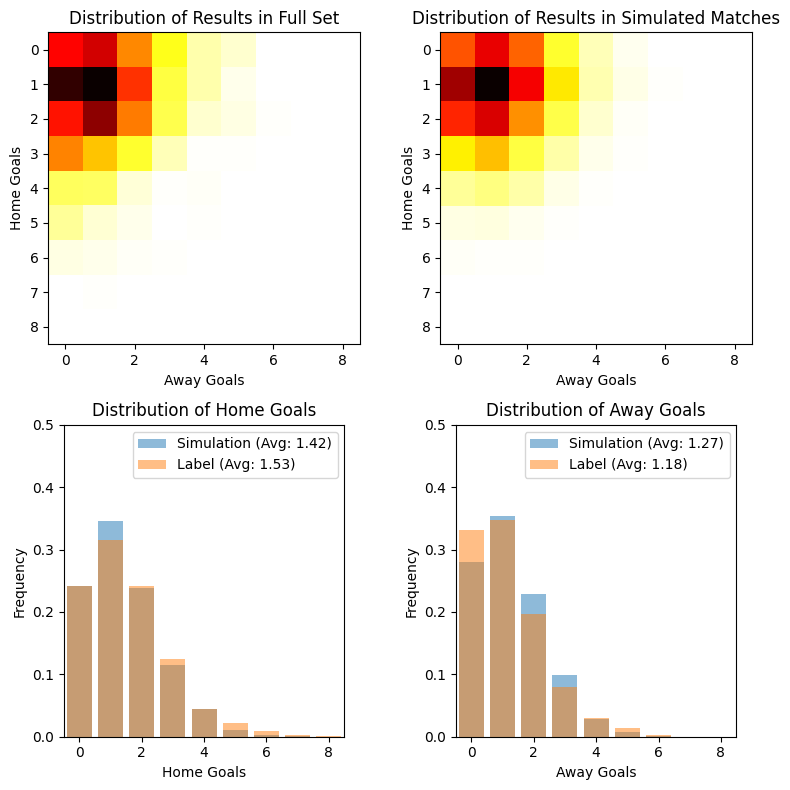

In [9]:
plt.rcParams['figure.figsize'] = (8, 8)
df_base = pd.concat([
    pd.read_csv('data/extras/E0-1718.csv'),
    pd.read_csv('data/extras/F0-1718.csv'),
    pd.read_csv('data/extras/SP0-1718.csv'),
    pd.read_csv('data/extras/I0-1718.csv'),
    pd.read_csv('data/extras/D0-1718.csv'),
])
plt.subplot(221)
plt.title('Distribution of Results in Full Set')
plt.imshow(df_base.pivot_table(index='FTHG', columns='FTAG', values='Date', aggfunc='count'), cmap='hot_r')
plt.ylim(8.5, -0.5)
plt.xlim(-0.5, 8.5)
plt.ylabel('Home Goals')
plt.xlabel('Away Goals')
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(222)
plt.title('Distribution of Results in Simulated Matches')
plt.imshow(data.pivot_table(index='home_score', columns='away_score', values='x', aggfunc='count'), cmap='hot_r')
plt.ylim(8.5, -0.5)
plt.xlim(-0.5, 8.5)
plt.ylabel('Home Goals')
plt.xlabel('Away Goals');
plt.gca().set_aspect('equal', adjustable='box')

df_results = pd.DataFrame(feature_tensor[:, 40:42] * 10, columns=['HG', 'AG'])
plt.subplot(223)
plt.bar(df_results.groupby('HG').HG.count().index, df_results.groupby('HG').HG.count()/df_results.groupby('HG').HG.count().sum(), alpha=0.5, label=f'Simulation (Avg: {df_results["HG"].mean():.2f})')
plt.bar(df_base.groupby('FTHG').FTHG.count().index, df_base.groupby('FTHG').FTHG.count()/df_base.groupby('FTHG').FTHG.count().sum(), alpha=0.5, label=f'Label (Avg: {df_base["FTHG"].mean():.2f})')
plt.legend();
plt.title('Distribution of Home Goals')
plt.xlabel('Home Goals')
plt.ylabel('Frequency')
plt.xlim(-0.5, 8.5)
plt.ylim(0, 0.5)
plt.gca().set_aspect(20, adjustable='box')

plt.subplot(224)
plt.bar(df_results.groupby('AG').AG.count().index, df_results.groupby('AG').AG.count()/df_results.groupby('AG').AG.count().sum(), alpha=0.5, label=f'Simulation (Avg: {df_results["AG"].mean():.2f})')
plt.bar(df_base.groupby('FTAG').FTAG.count().index, df_base.groupby('FTAG').FTAG.count()/df_base.groupby('FTAG').FTAG.count().sum(), alpha=0.5, label=f'Label (Avg: {df_base["FTAG"].mean():.2f})')
plt.legend();
plt.xlim(-0.5, 8.5)
plt.ylim(0, 0.5)
plt.title('Distribution of Away Goals')
plt.xlabel('Away Goals')
plt.ylabel('Frequency')
plt.gca().set_aspect(20, adjustable='box')

plt.tight_layout()
plt.savefig('figures/paper_lem/distribution_matching.pdf', bbox_inches='tight')

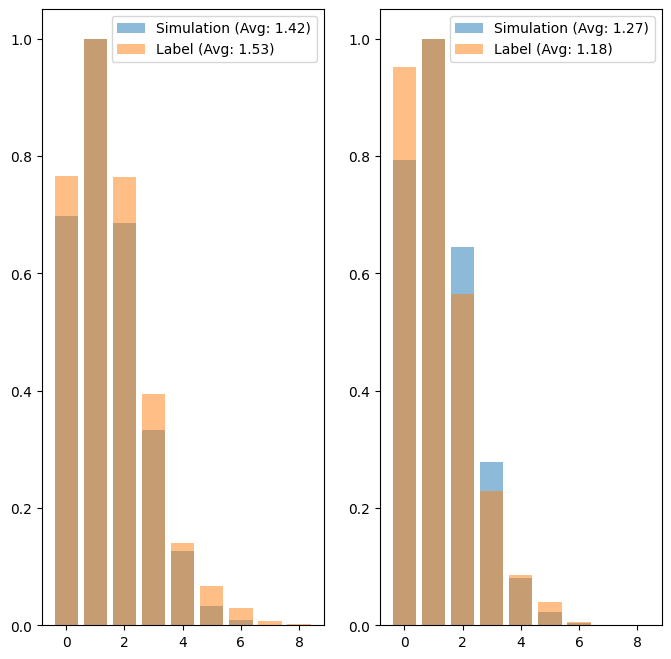

In [10]:
df_results = pd.DataFrame(feature_tensor[:, 40:42] * 10, columns=['HG', 'AG'])
plt.subplot(121)
plt.bar(df_results.groupby('HG').HG.count().index, df_results.groupby('HG').HG.count()/df_results.groupby('HG').HG.count().max(), alpha=0.5, label=f'Simulation (Avg: {df_results["HG"].mean():.2f})')
plt.bar(df_base.groupby('FTHG').FTHG.count().index, df_base.groupby('FTHG').FTHG.count()/df_base.groupby('FTHG').FTHG.count().max(), alpha=0.5, label=f'Label (Avg: {df_base["FTHG"].mean():.2f})')
plt.legend();
plt.subplot(122)
plt.bar(df_results.groupby('AG').AG.count().index, df_results.groupby('AG').AG.count()/df_results.groupby('AG').AG.count().max(), alpha=0.5, label=f'Simulation (Avg: {df_results["AG"].mean():.2f})')
plt.bar(df_base.groupby('FTAG').FTAG.count().index, df_base.groupby('FTAG').FTAG.count()/df_base.groupby('FTAG').FTAG.count().max(), alpha=0.5, label=f'Label (Avg: {df_base["FTAG"].mean():.2f})')
plt.legend();

plt.savefig('figures/paper_lem/distribution_scores.pdf', bbox_inches='tight')

In [11]:
data = pd.DataFrame(torch.concat(all_sims_data))
data[data.columns[0:33]].sum().plot.bar(figsize=(20, 10));

: 

: 

In [ ]:
df_all_data = []
for i in range(len(all_sims_data)):
    data = pd.DataFrame(all_sims_data[i])
    data['type_id'] = data[data.columns[:33]].idxmax(axis=1) + 1
    data = data.drop(data.columns[:33], axis=1)
    data.columns = ['period', 'minute', 'x', 'y', 'is_home_team', 'accurate', 'goal', 'home_score', 'away_score', 'type_id']
    data['event_id'] = i
    data['game_id'] = [i for i in range(len(all_sims_data[i]))]
    df_all_data.append(data)

In [ ]:
df_all_data = pd.concat(df_all_data)
df_all_data.minute *= 60
df_all_data.x *= 100
df_all_data.y *= 100
df_all_data.home_score = (df_all_data.home_score * 10).astype(int)
df_all_data.away_score = (df_all_data.away_score * 10).astype(int)
df_all_data['type_name'] = df_all_data.type_id.map({v: k for k, v in SUBEVENT_TYPE_MAP.items()})
df_all_data = df_all_data.reset_index(drop=True)

In [ ]:
df_all_data.sample(10)

,period,minute,x,y,is_home_team,accurate,goal,home_score,away_score,type_id,event_id,game_id,type_name
1773888,2.0,7.749999,71.000000,89.0,1.0,0.0,0.0,1,2,22,1773,888,touch
850646,1.0,6.699998,61.000000,74.0,0.0,1.0,0.0,0,3,28,850,646,simple_pass
1565632,1.0,38.049976,47.000000,94.0,1.0,0.0,0.0,2,2,22,1565,632,touch
1256374,1.0,29.833332,60.000004,5.0,0.0,1.0,0.0,3,0,28,1256,374,simple_pass
1324845,1.0,32.599976,95.000000,6.0,0.0,0.0,0.0,0,1,23,1324,845,cross
871108,1.0,5.450000,10.000000,48.0,0.0,0.0,0.0,1,0,1,871,108,air_duel
1773232,2.0,13.483326,54.000004,55.0,0.0,1.0,0.0,1,2,28,1773,232,simple_pass
206808,0.0,13.266663,100.000000,0.0,0.0,0.0,0.0,0,0,16,206,808,goal_kick
1117100,1.0,17.816654,44.000000,81.0,0.0,0.0,0.0,1,0,25,1117,100,head_pass
952867,1.0,7.499997,71.000000,96.0,1.0,0.0,0.0,0,2,28,952,867,simple_pass


In [ ]:
df_all_data[df_all_data.period <= 1].groupby('game_id').minute.count().mean(), df_train.groupby('match_id').minute.count().mean()

(1575.54, 1612.232645403377)

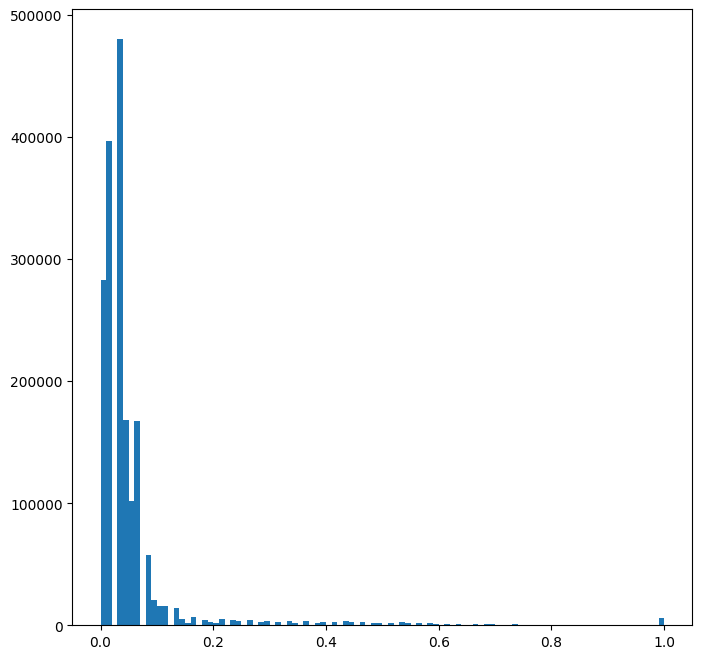

In [ ]:
diffs = []
for game_id in df_all_data.game_id.unique():
    diffs.append(df_all_data[df_all_data.game_id == game_id].minute.diff().dropna().values)
diffs = np.concatenate(diffs)
diffs = diffs[diffs > -10]
plt.hist(diffs, bins=100);

In [ ]:
len(df_all_data), df_all_data.goal.sum(), df_all_data[df_all_data.type_name.isin(['shot', 'penalty', 'free_kick_shot'])].goal.sum(), data.home_score.sum()*10, data.away_score.sum()*10

(1832000, 6125.0, 3091.0, 1359.0000915527344, 1286.0000610351562)

In [ ]:
[
    len(df_all_data[df_all_data.type_name == 'shot']), 
    df_all_data.goal.sum(), 
    df_all_data[df_all_data.type_name == 'shot'].goal.sum(), 
    df_all_data[df_all_data.type_name == 'penalty'].goal.sum(), 
    df_all_data[df_all_data.type_name == 'direct_free_kick'].goal.sum(), 
    len(df_all_data[df_all_data.type_name == 'shot']) / len(df_all_data), 
    df_all_data[df_all_data.type_name == 'shot'].goal.sum()/len(df_all_data[df_all_data.type_name == 'shot']),
]

[26782, 6125.0, 2821.0, 206.0, 0.0, 0.014618995633187772, 0.10533193936225824]

In [ ]:
pd.DataFrame([{
    'goal': round(df_all_data['goal'].sum() / len(df_all_data) * 100,3),
    'goal/shot': round(df_all_data[df_all_data.type_name == 'shot'].goal.sum() / len(df_all_data[df_all_data.type_name == 'shot']) * 100,3),
    'shot': round(len(df_all_data[df_all_data.type_name == 'shot']) / len(df_all_data) * 100,2), 
    'simple_pass': round(len(df_all_data[df_all_data.type_name == 'simple_pass']) / len(df_all_data) * 100,1), 
    'ground_attacking_duel': round(len(df_all_data[df_all_data.type_name == 'ground_attacking_duel']) / len(df_all_data) * 100,1), 
    'ground_defending_duel': round(len(df_all_data[df_all_data.type_name == 'ground_defending_duel']) / len(df_all_data) * 100,1), 
    'touch': round(len(df_all_data[df_all_data.type_name == 'touch']) / len(df_all_data) * 100,1), 
    'air_duel': round(len(df_all_data[df_all_data.type_name == 'air_duel']) / len(df_all_data) * 100,1), 
    'high_pass': round(len(df_all_data[df_all_data.type_name == 'high_pass']) / len(df_all_data) * 100,1), 
    'throw_in': round(len(df_all_data[df_all_data.type_name == 'throw_in']) / len(df_all_data) * 100,1), 
    'cross': round(len(df_all_data[df_all_data.type_name == 'cross']) / len(df_all_data) * 100,1), 
    'free_kick': round(len(df_all_data[df_all_data.type_name == 'free_kick']) / len(df_all_data) * 100,1), 
    'foul': round(len(df_all_data[df_all_data.type_name == 'foul']) / len(df_all_data) * 100,1), 
},
{
    'goal': round(df_train['goal'].sum() / len(df_train) * 100,3),
    'goal/shot': round(df_train[df_train.subtype_name == 'shot'].goal.sum() / len(df_train[df_train.subtype_name == 'shot']) * 100,3),
    'shot': round(len(df_train[df_train.subtype_name == 'shot']) / len(df_train) * 100,2), 
    'simple_pass': round(len(df_train[df_train.subtype_name == 'simple_pass']) / len(df_train) * 100,1), 
    'ground_attacking_duel': round(len(df_train[df_train.subtype_name == 'ground_attacking_duel']) / len(df_train) * 100,1), 
    'ground_defending_duel': round(len(df_train[df_train.subtype_name == 'ground_defending_duel']) / len(df_train) * 100,1), 
    'touch': round(len(df_train[df_train.subtype_name == 'touch']) / len(df_train) * 100,1), 
    'air_duel': round(len(df_train[df_train.subtype_name == 'air_duel']) / len(df_train) * 100,1), 
    'high_pass': round(len(df_train[df_train.subtype_name == 'high_pass']) / len(df_train) * 100,1), 
    'throw_in': round(len(df_train[df_train.subtype_name == 'throw_in']) / len(df_train) * 100,1), 
    'cross': round(len(df_train[df_train.subtype_name == 'cross']) / len(df_train) * 100,1), 
    'free_kick': round(len(df_train[df_train.subtype_name == 'free_kick']) / len(df_train) * 100,1), 
    'foul': round(len(df_train[df_train.subtype_name == 'foul']) / len(df_train) * 100,1), 
}])

,goal,goal/shot,shot,simple_pass,ground_attacking_duel,ground_defending_duel,touch,air_duel,high_pass,throw_in,cross,free_kick,foul
0,0.334,10.533,1.46,42.8,8.1,8.3,5.2,6.2,4.1,2.5,2.1,1.4,1.4
1,0.333,10.291,1.40,41.4,9.1,9.0,5.7,5.2,4.2,2.8,2.0,1.5,1.6


In [ ]:
df_all_data[['goal', 'type_name']].value_counts()

goal  type_name              
0.0   simple_pass                784870
      ground_defending_duel      152692
      ground_attacking_duel      148491
      air_duel                   112901
      touch                       95073
      ground_loose_ball_duel      90964
      high_pass                   75596
      head_pass                   54464
      throw_in                    45610
      cross                       38416
      clearance                   31803
      foul                        26541
      free_kick                   25933
      shot                        23961
      launch                      23424
      goal_kick                   18197
      smart_pass                  16384
      acceleration                15629
      corner                      13428
      hand_pass                    9688
      free_kick_cross              5145
      save_attempt                 4925
      reflexes                     4550
      goalkeeper_leaving_line      4286
1.0   shot